# Prep

In [1]:
pkgs = c(
    'tidyverse',
    'deSolve',
    'DiagrammeR', 'vtree', 'IRdisplay', 'base64enc',
    'patchwork',
    'scales',
    'zoo'
)
for(pkg in pkgs) {
    if(! require(character.only = TRUE, pkg)) {
        install.packages(pkg)
        require(character.only = TRUE, pkg)
    }
}

Loading required package: tidyverse

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: deSolve

Loading required package: DiagrammeR

Loading required package: vtree

Loading required package: IRdisplay

Loading required package: base64enc

Loading required package: patchwork

Loading required package: scales


Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor


Loading required p

# Utils

In [2]:
timeit = \(expr) {
    start = Sys.time()
    res = eval.parent(expr)
    show(Sys.time() - start)
    res
}

In [3]:
figsize = \(width=6, height=4) {
    options(repr.plot.width = width, repr.plot.height = height)
}

In [4]:
make.model = \(spec) {
    state = list()
    body = list()
    push.state = \(k,v) state[[k]][[length(state[[k]])+1]] <<- v
    push.body = \(v) body[[length(body)+1]] <<- v
    
    env = list(
        move = \(from,to,count, ...) {            
            push.state(substitute(from), bquote((- .(substitute(count)))))
            push.state(substitute(to), substitute(count))
        },
        '<-' = \(lhs, rhs) {
            push.body(bquote(.(substitute(lhs)) <- .(substitute(rhs))))
        },
        add = \(to, count, ...) {
            push.state(substitute(to), substitute(count))
        }
    )
    env['='] = env['<-']
    
    do.call(with, list(env, spec[[3]]))
    
    for(k in names(state)) {
        rhs = Reduce(\(acc,x) bquote(.(acc) + .(x)), state[[k]])
        push.body(bquote(du[.(as.symbol(k))] <- .(rhs)))
    }

    eval.parent(call('function', spec[[2]], bquote(splice=TRUE, {
        du = c()
        ..(body)
        list(du[names(u)])
    })))
}

In [5]:
make.graph = \(spec, width=400, height=400, aux='') {
    desub = \(x) eval.parent(bquote(deparse(substitute(.(substitute(x))))))
    label = list()
    edge = list()
    push.label = \(x) label[length(label)+1] <<- x
    push.edge = \(x) edge[length(edge)+1] <<- x
    env = list(
        move = \(from,to,count, ...) {
            push.edge(sprintf('%s -> %s [label=<%s>]', 
                              desub(from), desub(to), desub(count)))
        },
        '<-' = \(lhs, rhs, ...) {
            push.label(sprintf('%s = %s', desub(lhs), desub(rhs)))
        },
        add = \(to, count, loop=FALSE) {
            if(loop) 
                push.edge(sprintf('%s -> %s [label=<%s>]', desub(to), desub(to), desub(count)))
            else 
                push.edge(sprintf('_ -> %s [label=<%s>]', desub(to), desub(count)))
        }
    )
    env['='] = env['<-']
    do.call(with, list(env, spec[[3]]))
    
    g = grViz(width=width, height=height, sprintf(
        'digraph {
            %s
            _ [label="", shape=none]
            label = <%s>
            %s
        }',
        aux,
        do.call(paste, c(label, sep='<br/>')),
        do.call(paste, c(edge, sep='\n'))
    ))

    fname = tempfile(tmpdir = '.', fileext='.png')
    grVizToPNG(g, filename = fname, width = width, height = height)
    img = readBin(fname, 'raw', file.info(fname)$size)
    b64 = base64encode(img)
    file.remove(fname)
    display_html(paste0('<img src="data:image/png;base64,', b64, '"/>'))
}

## Usage

In [6]:
# spec is the descriptive specification of a compartment model
# at time t, with state u, and parameter p.
# compartment indices S, I, and R are to be used inside state u 
# to get the count of each compartments.
spec = quote(\(t,u,p) {
    N = u[S] + u[I] + u[R]
    # move(A, B, count) subtracts the count from the compartment A 
    # and adds the same to the compartment B.
    move(S, I, p$beta*u[I]/N*u[S])
    move(I, R, p$gamma*u[I])
    move(R, S, p$mu*u[R])
})

In [7]:
make.model(spec)

function (t, u, p) 
{
    du = c()
    N <- u[S] + u[I] + u[R]
    du[S] <- (-(p$beta * u[I]/N * u[S])) + p$mu * u[R]
    du[I] <- p$beta * u[I]/N * u[S] + (-(p$gamma * u[I]))
    du[R] <- p$gamma * u[I] + (-(p$mu * u[R]))
    list(du[names(u)])
}


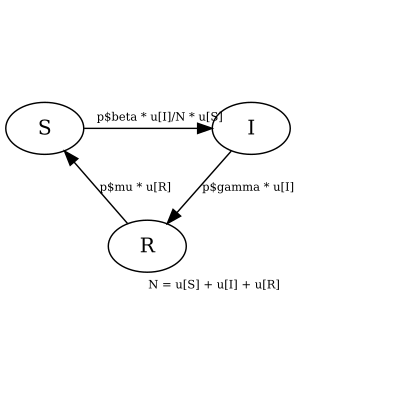

In [8]:
make.graph(spec, aux='
    graph [fontsize=8]
    edge [fontsize=8]
    { rank=same S I}
')

# SIR model with partial protection and seasonal forcing

## Model

In [9]:
# compartments
S = 'susceptible'
I = 'infective'
R = 'recovered'
A = 'exposed before the loss of immunity'
full_inf = 'total infection after the loss of immunity'
part_inf = 'total infection before the loss of immunity'

spec = quote(\(t,u,p) {
    G = p$generation.time
    M = p$immunity.longevity
    beta = p$R0 / G
    kappa = p$relative.infectivity
    lambda = p$relative.susceptibility

    N = u[S] + u[I] + u[R] + u[A]
    J = beta*(u[I] + kappa*u[A])/N * p$seasonal.forcing(t)
    
    move(S, I, J*u[S])
    move(I, R, u[I]/G)
    move(R, S, u[R]/M)
    
    move(R, A, J*lambda*u[R])
    move(A, R, u[A]/G)
    
    add(full_inf, J*u[S])
    add(part_inf, J*lambda*u[R])
})

In [10]:
make.model(spec)

function (t, u, p) 
{
    du = c()
    G <- p$generation.time
    M <- p$immunity.longevity
    beta <- p$R0/G
    kappa <- p$relative.infectivity
    lambda <- p$relative.susceptibility
    N <- u[S] + u[I] + u[R] + u[A]
    J <- beta * (u[I] + kappa * u[A])/N * p$seasonal.forcing(t)
    du[S] <- (-(J * u[S])) + u[R]/M
    du[I] <- J * u[S] + (-(u[I]/G))
    du[R] <- u[I]/G + (-(u[R]/M)) + (-(J * lambda * u[R])) + 
        u[A]/G
    du[A] <- J * lambda * u[R] + (-(u[A]/G))
    du[full_inf] <- J * u[S]
    du[part_inf] <- J * lambda * u[R]
    list(du[names(u)])
}


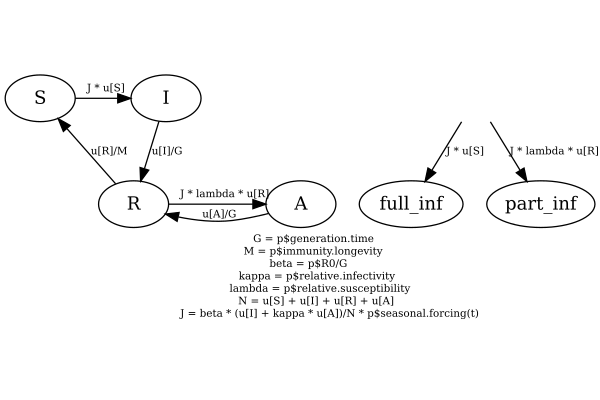

In [11]:
make.graph(spec, width=600, height=400, aux='
    edge [fontsize=8]
    graph [fontsize=8]
    { rank=same S I }
    { rank=same R A }
')

## Seasonal forcing

Rows: 12 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (2): month, Re

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


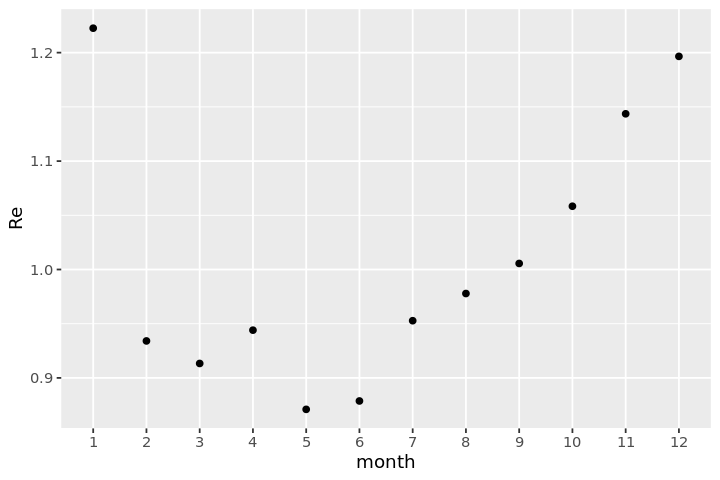

In [12]:
# see ./R-seasonal-forcing-japan.ipynb
flu.Re = read_csv('data/flu-Re-monthly.csv')
time2Re = rep(flu.Re$Re, c(31,28,31,30,31,30, 31,31,30,31,30,31))
smoothed.time2Re = rollmean(rep(time2Re, 3), 30)[(1:365)+365-30%/%2]
seasonal.forcing = \(t) {
    # using smoothed version makes ode much slower 
    # with no significant changes of the result
    # smoothed.time2Re[[(t-1)%%365+1]] 
    time2Re[[(t-1)%%365+1]]
}

figsize(6,4)
flu.Re %>%
    mutate(month = as.factor(month)) %>%
    ggplot() +
    geom_point(aes(month, Re))

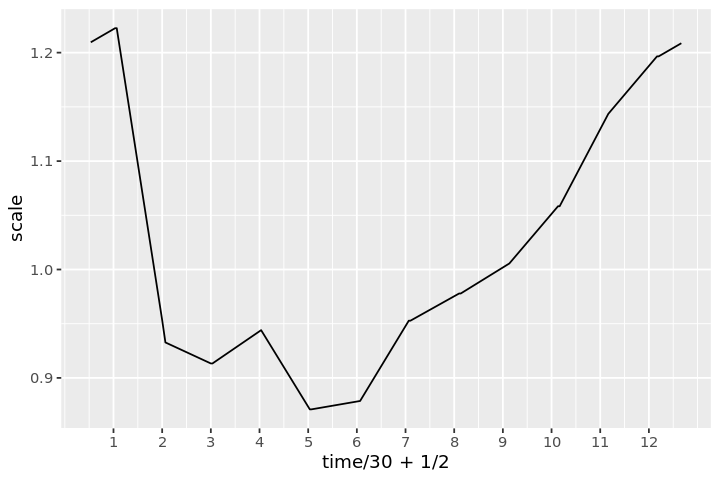

In [13]:
figsize(6,4)
data.frame(
    time = seq(365),
    scale = smoothed.time2Re
) %>%
    ggplot() +
    geom_line(aes(time/30+1/2, scale)) +
    scale_x_continuous(breaks = seq(12))

## Plots

In [14]:
make.plot = \(params) {
    # ref = \(index) as.symbol(str_replace_all(index, ' ', '.'))
    
    u0 = c()
    u0[S] = 126e6
    u0[I] = 1
    u0[R] = 0
    u0[A] = 0
    u0[full_inf] = 0
    u0[part_inf] = 0

    sol = ode(
        y = u0,
        times = seq(0, 365*20),
        func = make.model(spec),
        parms = params
    )

    data.frame(sol) %>%
        # mutate(
        #     total.infection = !!ref(full_inf) + !!ref(part_inf)
        # ) %>%
        transmute(
            across(!starts_with('total.')),
            across(starts_with('total.'), ~ . - lag(., default = 0), 
                   .names = '{str_replace(col, "total", "new")}')
        ) %>%
        tail(365*3) %>%
        pivot_longer(-time) %>%
        rename(
            day = time,
            count = value
        ) %>%
        ggplot() +
        geom_line(aes(day/365, count, color=name)) +
        scale_x_continuous(
            minor_breaks = breaks_width(width = 1/12),
            breaks = breaks_width(width = 1/2)
        ) +
        # scale_y_continuous(
        #     breaks = scales::breaks_pretty(n=10),
        #     labels = scales::label_number_si('')
        # ) + 
        scale_y_log10(
            limits = c(1,NA), 
            breaks = scales::log_breaks(n=10, base=10),
            labels = label_number(scale_cut = cut_si(''))
        ) +
        labs(
            caption = str_glue('
                R0 = {params$R0}
                generation time = {params$generation.time}
                immunity longevity = {params$immunity.longevity}
                relative infectivity = {params$relative.infectivity}
                relative susceptibility = {params$relative.susceptibility}')
        ) +
        theme_bw()
}

In [15]:
params = list(
    seasonal.forcing = seasonal.forcing,
    R0 = 1,
    generation.time = 3,
    immunity.longevity = 100,
    relative.infectivity = 0,
    relative.susceptibility = 0
)

Time difference of 9.679185 secs


Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”


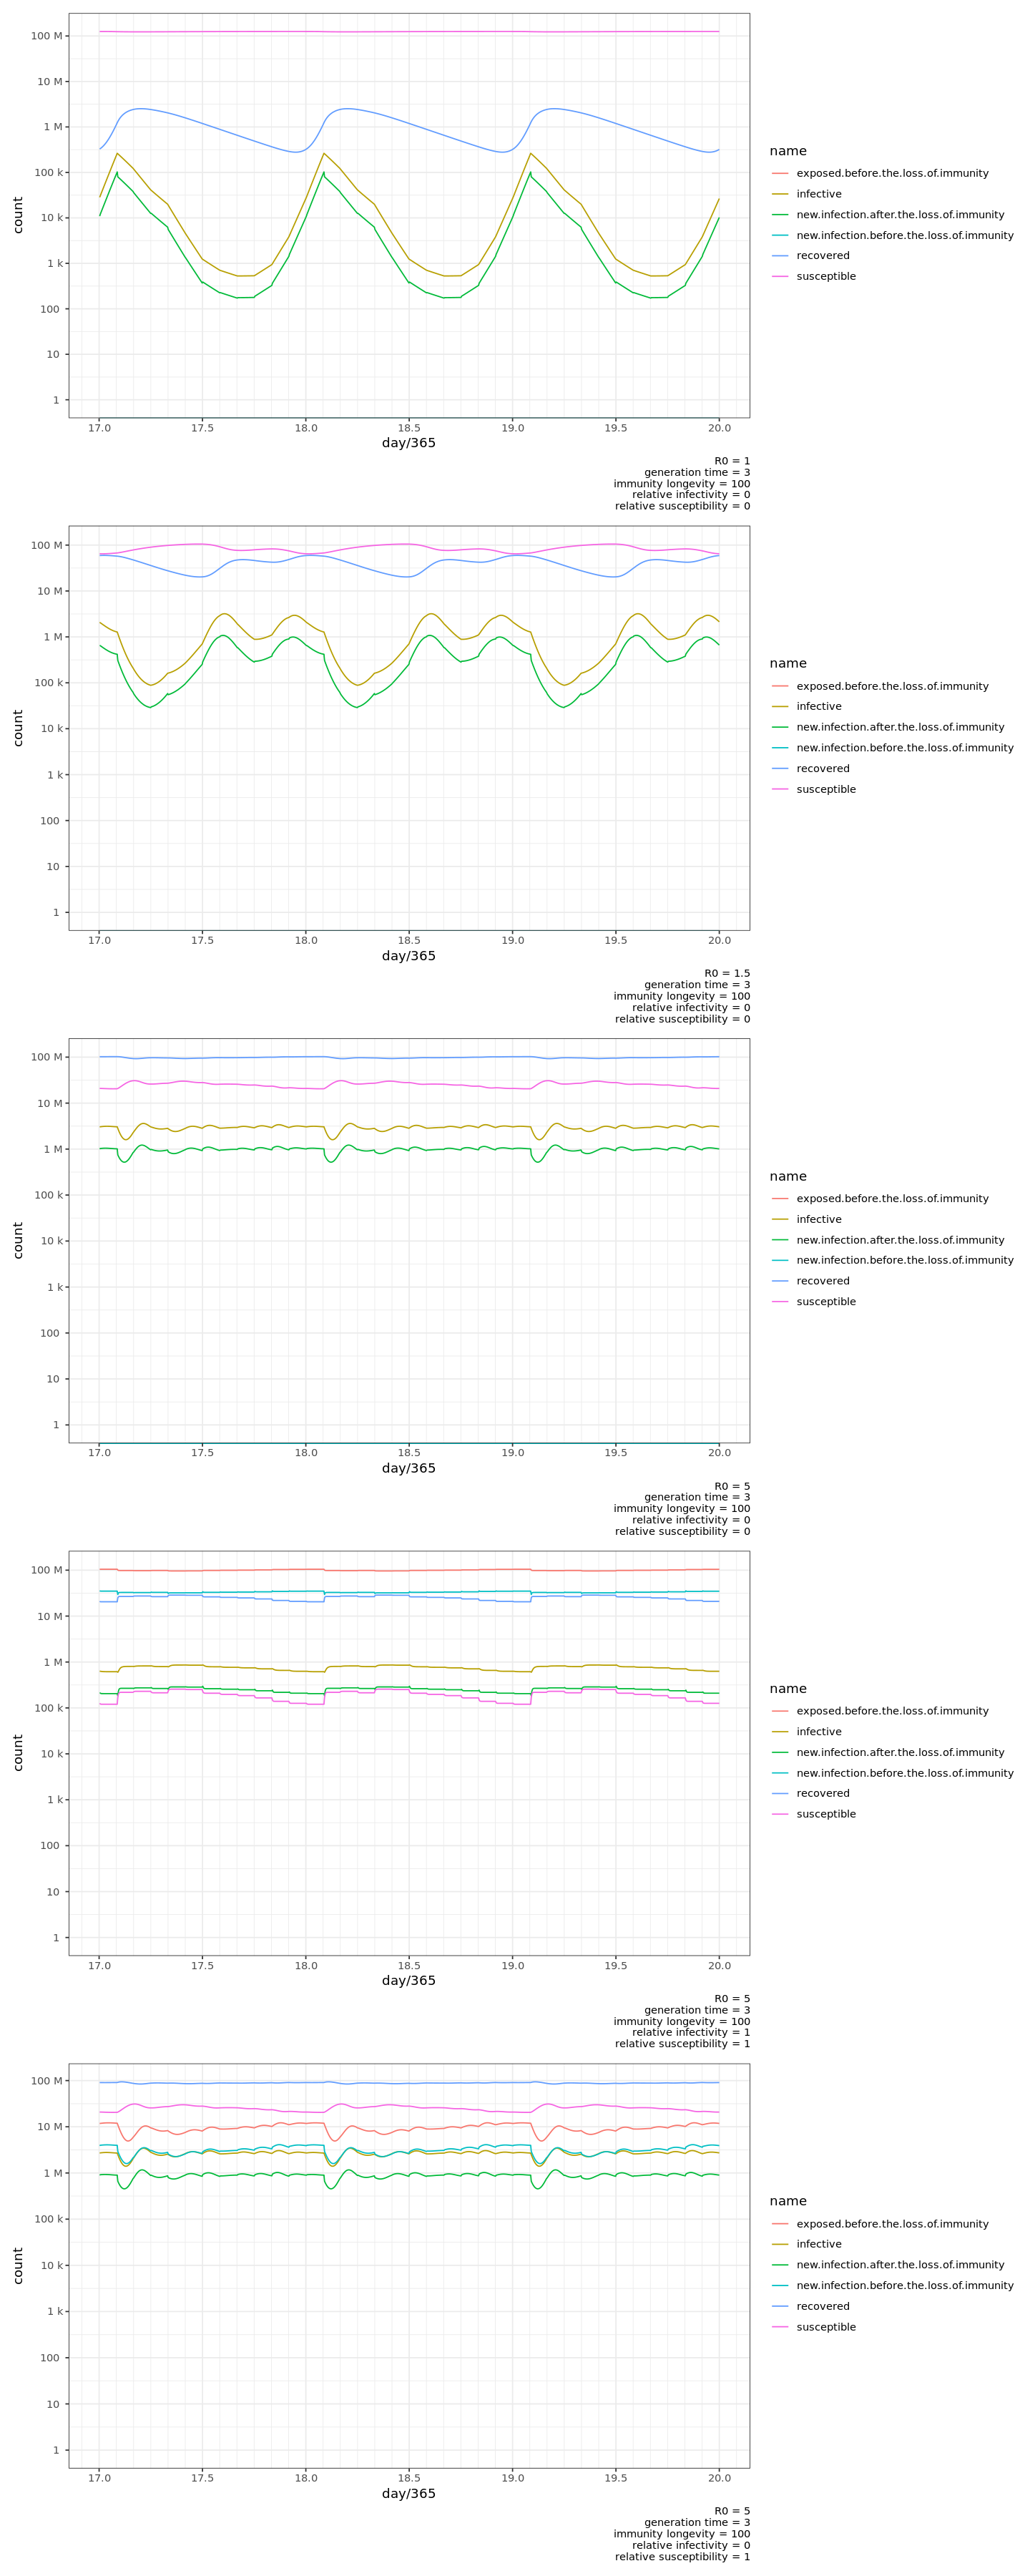

In [16]:
figsize(width=12, height=6*5)
timeit({
    make.plot(params) / 
    make.plot(c(R0=1.5, params)) /
    make.plot(c(R0=5, params)) /
    make.plot(c(R0=5, relative.infectivity=1, relative.susceptibility=1, params)) /
    make.plot(c(R0=5, relative.infectivity=0, relative.susceptibility=1, params))
})